In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv


Let's read the csv files using pandas read_csv which provides data in form of pandas dataframe.
Pandas offers lots of cool features to deal with csv data. [Official Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)<br>
Let's have a look at some features:
1.  By default read_csv consider 1st column as header and title for the column names. But it can be customized by passing an array as name.<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',name = ['name','Age','height','weight','Employee No'])

2.  Rows can be skipped as follows and it also support callbacks.<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',skiprows = 2) # From top it will skip 3 rows<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',skipfooter = 2) # From bottom it will skip 3 rows<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',nrows  = 5) # Only read 5 rows<br>

3. Only read a subset of the columns using usecols.<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',usecols = ['name','Employee No'])

4. For handling very large csv files, it can be read in chunks by specifying chunksize. It returns TextFileReader object.<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',chunksize  = 5)<br>
for chunk in data:<br>
$\;\;\;\;\;\;$print(chunk)<br>

5. Handle NaN values.<br>
Classify additional strings as NaN.<br>
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',',na_values = ['Not Applicable','TBD'])

Delete the rows which contains NaN data using dropna()<br>
data.dropna(inplace = False)

Or the better way is to replace NaN with a number depends on the data set.<br>
data['weight'].fillna(50, inplace=True)

In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',sep=',')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv',sep=',')

Have a look at train and test data.

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert dataframes into numpy array so it can be feed to the convolution neural network which will be created using tensorflow and keras.

In [5]:
train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype='float32')

Separate label data as y and image data as x and rescale it to (0,1) range from (0,255) range

In [6]:
x_train = train_data[:,1:]/255 #Skip 1st column as it is a label data
y_train = train_data[:,0] # 1st column is label
x_test= test_data[:,:]/255

Split training data as 80% training set and 20% validation set using scikit learn's train_test_split method.<br>
Validation set will not update weights and bias of the neural network.<br>
It is used to verify neural network performance before validating on test data.<br>

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)
print("x_train shape: " + str(x_train.shape))
print("x_validate shape: " + str(x_validate.shape))
print("x_test shape: " + str(x_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_validate shape: " + str(y_validate.shape))

x_train shape: (33600, 784)
x_validate shape: (8400, 784)
x_test shape: (28000, 784)
y_train shape: (33600,)
y_validate shape: (8400,)


Reshape the x data in the format -> (number of examples, height, width, channel)<br>
These are not RGB images hence channel is 1.

In [8]:
height = width = 28
x_train = x_train.reshape(x_train.shape[0],height,width,1)
x_validate = x_validate.reshape(x_validate.shape[0],height,width,1)
x_test = x_test.reshape(x_test.shape[0],height,width,1)
print("x_train shape: " + str(x_train.shape))
print("x_validate shape: " + str(x_validate.shape))
print("x_test shape: " + str(x_test.shape))

x_train shape: (33600, 28, 28, 1)
x_validate shape: (8400, 28, 28, 1)
x_test shape: (28000, 28, 28, 1)


Let's perform data augmentation for training data.<br>
Using this CNN model will see different set of images during each epoch training.<br>
This helps to generalize the data set which helps to improve test accuracy with a liite loss on training accuracy.<br>
[Image Data Augmentation using Keras](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)<br>
[Keras official documentation](https://keras.io/preprocessing/image/)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

Using TensorFlow backend.


In [10]:
from keras.models import Sequential
from keras.layers import Activation,Conv2D, MaxPooling2D, Dense, Dropout, Flatten

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer='glorot_uniform',input_shape=(height, width, 1),name='conv0'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='max_pool0'))
model.add(Dropout(0.25))
          
model.add(Conv2D(64, kernel_size=(3, 3), name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='max_pool1'))
model.add(Dropout(0.25))
          
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2'))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu',name = 'fc'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 5, 5, 64)         

Let's visualize the model

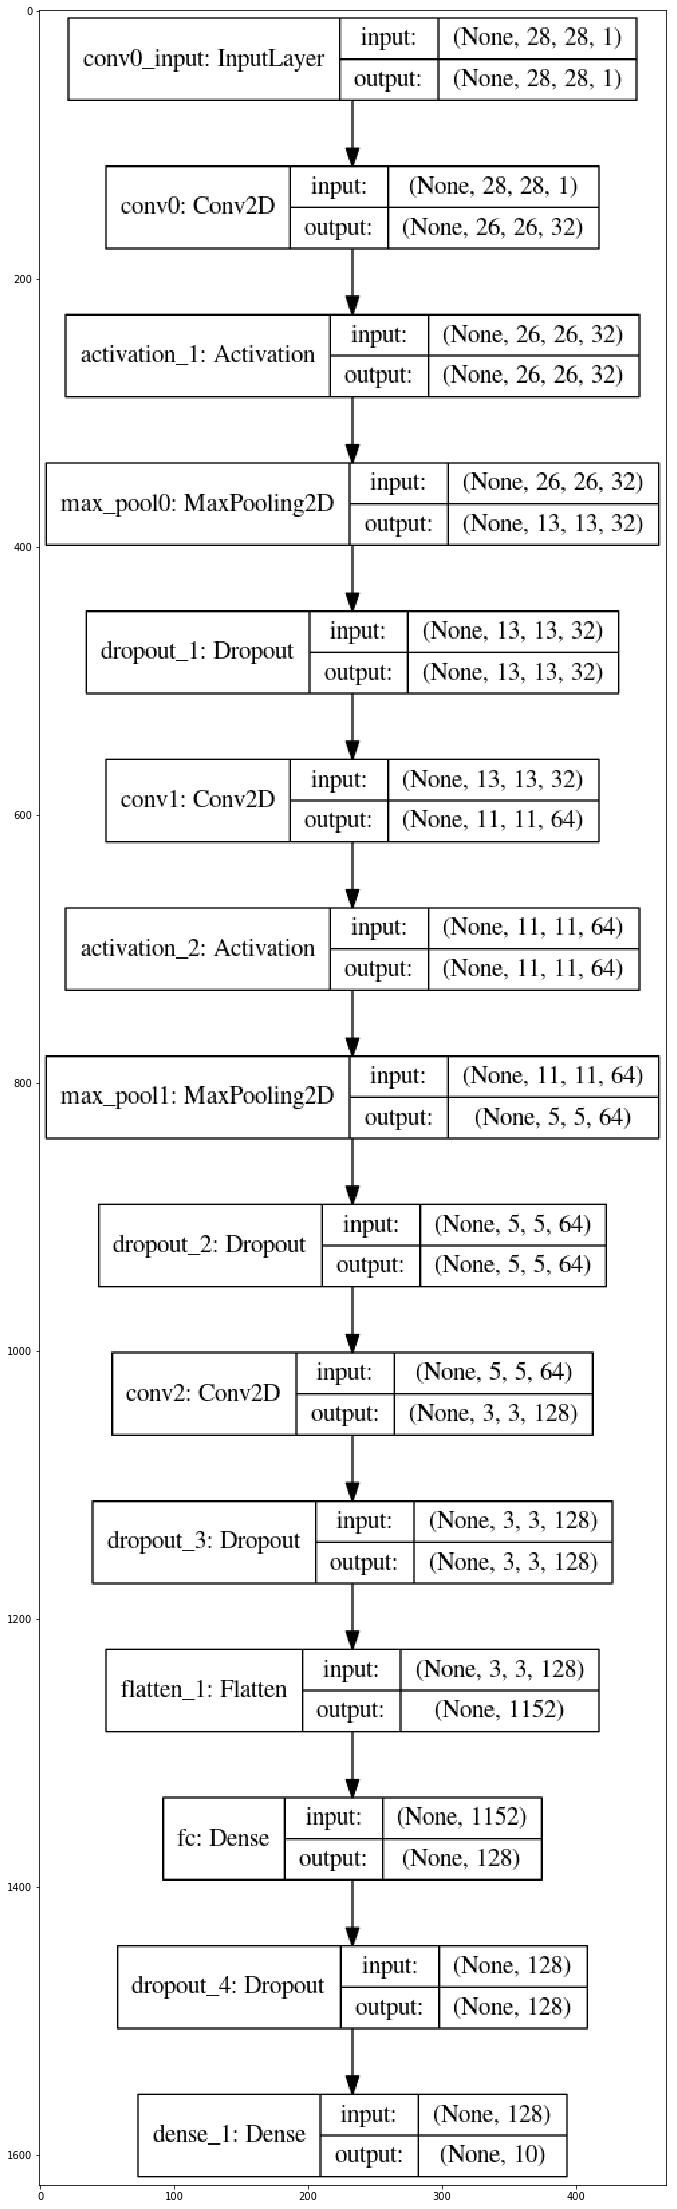

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import plot_model

plot_model(model,to_file='model.png',show_shapes = True, show_layer_names = True)
img = mpimg.imread('model.png')
plt.figure(figsize =(40,40))
plt.imshow(img)

In [12]:
model.compile(loss ='sparse_categorical_crossentropy', optimizer= 'Adam',metrics =['accuracy'])

Save the model when the lowest loss is achieved during epochs training iterations.

In [13]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = 'cnn.hdf5', verbose = 1, save_best_only = True)

In [14]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 128), epochs = 50, verbose=1,callbacks = [checkpoint],validation_data=(x_validate,y_validate))

Epoch 1/50
263/263 [==============================] - 20s 75ms/step - loss: 0.8149 - accuracy: 0.7259 - val_loss: 0.1134 - val_accuracy: 0.9655

Epoch 00001: val_loss improved from inf to 0.11337, saving model to cnn.hdf5
Epoch 2/50
263/263 [==============================] - 19s 73ms/step - loss: 0.2736 - accuracy: 0.9144 - val_loss: 0.0658 - val_accuracy: 0.9792

Epoch 00002: val_loss improved from 0.11337 to 0.06581, saving model to cnn.hdf5
Epoch 3/50
263/263 [==============================] - 19s 72ms/step - loss: 0.1912 - accuracy: 0.9418 - val_loss: 0.0549 - val_accuracy: 0.9840

Epoch 00003: val_loss improved from 0.06581 to 0.05492, saving model to cnn.hdf5
Epoch 4/50
263/263 [==============================] - 19s 73ms/step - loss: 0.1535 - accuracy: 0.9535 - val_loss: 0.0498 - val_accuracy: 0.9840

Epoch 00004: val_loss improved from 0.05492 to 0.04984, saving model to cnn.hdf5
Epoch 5/50
263/263 [==============================] - 19s 73ms/step - loss: 0.1360 - accuracy: 0.958

Based on the trained model let's predict digits from the test data

In [15]:
predicted_classes = model.predict_classes(x_test)
print(predicted_classes)

[2 0 9 ... 3 9 2]


Let's have a look at submission.csv file.

In [16]:
sample_submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv',sep = ',')
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [17]:
submission  = pd.DataFrame({
    "ImageId": range(1,x_test.shape[0] + 1),
    "Label": predicted_classes
})
submission.to_csv("submission.csv", index=False)
display(submission.head(3))
display(submission.tail(3))

,ImageId,Label
0,1,2
1,2,0
2,3,9


,ImageId,Label
27997,27998,3
27998,27999,9
27999,28000,2
